In [24]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import pickle
import warnings

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

from metaorf.modeling.etl import generate_orf_id, load_features
from metaorf.modeling.ensemble import plot_roc_pr, Dataset

from Bio.Seq import Seq
from pathlib import Path

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

warnings.filterwarnings('ignore')

In [2]:
bp_dir = Path('/home/ec2-user/velia-data-dev/VDC_004_annotation/big_prot/v0.8.1_minlen_15_maxlen_150/')

In [3]:
data_dir = Path('../data').absolute()

In [4]:
qc_samples = []
with open('../data/StringentQC_samples.txt', 'r') as infile:
    for line in infile.readlines():
        qc_samples.append(line.rstrip('\n').replace('_', '-'))

In [5]:
dataset_names = []
for feature_file in data_dir.glob('*orf_features.csv'):
    name = '-'.join(feature_file.name.split('_')[3:-2])
    if name in qc_samples: 
        dataset_names.append(feature_file.name)

In [6]:
call_names = []

for call_file in data_dir.glob('*any_caller.csv'):
    name = '-'.join(feature_file.name.split('_')[3:-2])
    if name in qc_samples: 
        call_names.append(call_file.name)

In [7]:
def return_passing_orf_ids(data_dir, call_files):
    """
    """

    filter_categories = ["3'UTR:CDSFrameOverlap", "5'UTR:CDSFrameOverlap", 'Annotated', 'annotated', 
                     'Internal:CDSFrameOverlap', 'Trunc', "5'UTR:Known", "3'UTR:Known", 'Internal:Known',
                     'Truncated', 'Truncated:Known', 'Extended', 'Extended:CDSFrameOverlap', 'Extended:Known']
    orf_ids = set()
    
    for call_file in call_files:
        df = pd.read_csv(data_dir.joinpath(call_file), sep='\t')
        tmp_df = df[(~df['ORF_type_price'].isin(filter_categories)) & \
                    (~df['ORF_type_ribotish'].isin(filter_categories)) & \
                    (~df['ORF_type_ribocode'].isin(filter_categories))]

        orf_ids = orf_ids.union(set(tmp_df.apply(lambda x: f'{x.chrom_id}_{x.orf_start}_{x.orf_end}_{x.strand}_{x.exon_blocks}', axis=1).values))

    return set(orf_ids)

In [8]:
overwrite=False

if overwrite:
    passing_orf_ids = return_passing_orf_ids(data_dir, call_names)
    with open('../data/novel_orf_ids.txt', 'w') as outfile:
        for orf_id in passing_orf_ids:
            outfile.write(f'{orf_id}\n')
else:
    passing_orf_ids = []
    with open('../data/novel_orf_ids.txt', 'r') as infile:
        for line in infile.readlines():
            passing_orf_ids.append(line.rstrip('\n'))

In [9]:
len(passing_orf_ids)

508904

In [10]:
overwrite = False
feature_file = data_dir.joinpath('orf_features_all.csv')

if not feature_file.exists() or overwrite:
    feature_all_df = load_features(data_dir, dataset_names)
    feature_all_df.to_csv(feature_file)
    drop_cols=['orf_start', 'orf_end']
    feature_df = feature_all_df.drop(columns=drop_cols)
    feature_df = feature_df.select_dtypes(include='number')
    feature_df.to_csv(data_dir.joinpath('orf_features_numeric.csv'))
else:
    feature_all_df = pd.read_csv(feature_file)
    feature_df = pd.read_csv(data_dir.joinpath('orf_features_numeric.csv'))


In [13]:
feature_df.shape

(17172147, 27)

In [15]:
10577-724

9853

In [16]:
feature_all_df.shape

(17172147, 35)

In [18]:
passing_orf_idx_strs = feature_all_df[feature_all_df['orf_idx_str'].isin(passing_orf_ids)].index

In [21]:
feature_df = feature_df.loc[passing_orf_idx_strs]

In [22]:
feature_df

,mean,sum,std,n_reads_orf_vs_transcript,pos_1_vs_0,pos_2_vs_0,frames_1_vs_0,frames_2_vs_0,five_utr_vs_cds_mean,five_utr_vs_cds_max,five_utr_vs_start_codon_mean,five_utr_vs_start_codon_max,cds_utr_vs_start_codon_mean,cds_utr_vs_start_codon_max,three_utr_vs_cds_mean,three_utr_vs_cds_max,three_utr_vs_stop_codon_mean,three_utr_vs_stop_codon_max,cds_utr_vs_stop_codon_mean,cds_utr_vs_stop_codon_max,dist_neg_100,dist_neg_150,dist_pos_100,dist_pos_150,price,ribotish,ribocode
orf_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
chr1_27234901_27234913_+_27234901-27234913_VPR-orfcalling-20240308012528-SRX11811978,0.077680,0.932161,0.101100,1.000000,1.000000,0.000000,0.400000,0.000000,1.123852,0.301030,1.102662,0.301030,-0.051153,-0.000000,3.000000,3.00000,3.000000,3.00000,0.176091,-0.000000,-1.230449,-1.778151,-0.000000,-0.477121,1.806180,0.0,0.000000
chr1_105893328_105893421_+_105893328-105893421_VPR-orfcalling-20240308012528-SRX11811978,0.052980,4.927136,0.219327,1.000000,0.000000,0.000000,0.060606,0.060606,0.584923,0.698970,0.500602,-0.000000,-0.096910,-0.698970,3.000000,3.00000,-3.000000,-3.00000,-3.000000,-3.000000,-1.380211,-1.778151,-1.322219,-1.431364,4.500918,0.0,0.000000
chr1_42459788_42459926_+_42459788-42459926_VPR-orfcalling-20240308012528-SRX11811978,0.021229,2.929648,0.068479,1.000000,10.000000,10.000000,0.166667,0.055556,0.479413,0.477121,0.801632,0.477121,0.410174,0.176091,3.000000,3.00000,3.000000,3.00000,0.255273,-0.477121,-0.000000,-0.000000,-0.000000,-0.000000,5.413143,0.0,0.000000
chr1_27325712_27325796_+_27325712-27325796_VPR-orfcalling-20240308012528-SRX11811978,1.393485,117.052762,3.757376,1.000000,0.078947,0.052632,0.090387,0.170732,2.136947,1.412180,2.343627,1.278754,0.253199,-0.133427,3.000000,3.00000,-3.000000,-3.00000,-3.000000,-3.000000,-1.778151,-1.778151,-0.477121,-0.477121,9.132226,0.0,0.000000
chr1_28236183_28237978_+_28236183-28236270|28236360-28236452|28237836-28237978_VPR-orfcalling-20240308012528-SRX11811978,0.428952,137.693463,1.253429,0.994231,0.039604,0.019802,0.100457,0.079909,1.020992,1.226170,1.690934,1.226170,1.081992,0.828230,1.484768,1.09108,2.373372,1.09108,1.092244,0.337753,-1.778151,-1.778151,-1.778151,-1.778151,15.431716,0.0,24.991714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr11_86302448_86345638_+_86302448-86302478|86306244-86306482|86337378-86337530|86344662-86344721|86345583-86345638_VPR-orfcalling-20240308012940-SRX876071,0.025901,13.831328,0.077061,0.887500,0.000000,0.000000,0.133333,0.444444,0.298957,-0.000000,0.579784,-0.301030,0.352183,-0.301030,3.000000,3.00000,3.000000,3.00000,0.653213,-0.000000,-0.000000,-1.176091,-0.778151,-1.681241,0.000000,0.0,7.008212
chr11_86337407_86345094_+_86337407-86337530|86344602-86344721|86345093-86345094_VPR-orfcalling-20240308012940-SRX876071,0.028059,6.818260,0.082856,1.000000,0.000000,0.000000,0.000000,0.346154,0.007687,-0.000000,0.199572,-0.301030,0.234083,-0.301030,3.000000,3.00000,-3.000000,-3.00000,-3.000000,-3.000000,-1.079181,-1.397940,-0.477121,-1.380211,0.000000,0.0,4.559144
chr2_96013921_96019537_+_96013921-96013971|96015108-96015325|96019200-96019260|96019480-96019537_VPR-orfcalling-20240308012940-SRX876071,0.006595,2.532497,0.040455,0.928571,10.000000,10.000000,0.000000,0.857143,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.00000,-3.000000,-3.00000,-3.000000,-3.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.0,2.869699


In [43]:
feature_df.set_index('orf_id', inplace=True)

In [18]:
len(set(feature_all_df['orf_idx_str']))

687671

In [20]:
len(set(feature_all_df['orf_sequence']))

672122

In [11]:
len(set(feature_df.index))

17172147

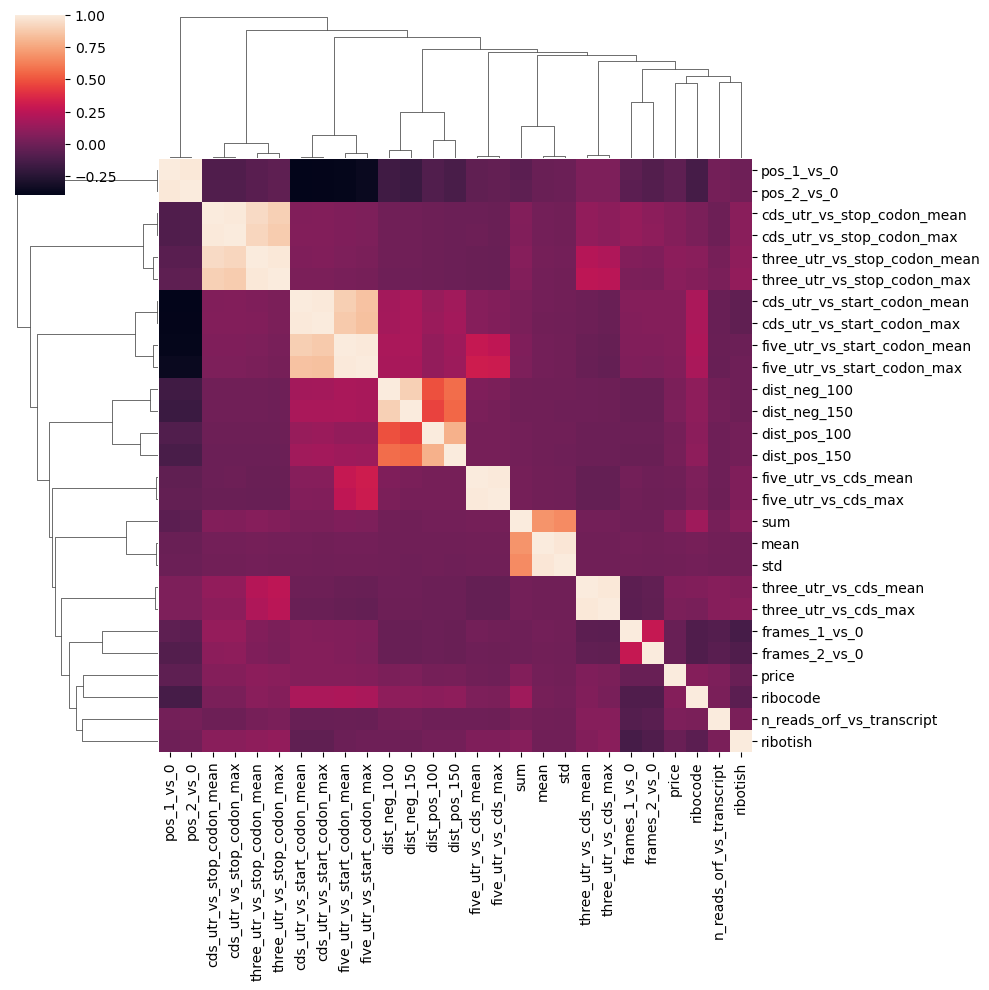

In [12]:
sns.clustermap(feature_df.corr())

In [34]:
with open('../data/top_model_all_gb.pkl', 'rb') as file:
    ds = pickle.load(file)

In [35]:
ds.model = ds.model.fit(ds.X, ds.y)

In [36]:
predictions = ds.model.predict(feature_df)

In [37]:
prediction_proba = ds.model.predict_proba(feature_df)

In [38]:
feature_df['prediction'] = predictions

In [39]:
feature_df['prediction_proba'] = prediction_proba[:,1]

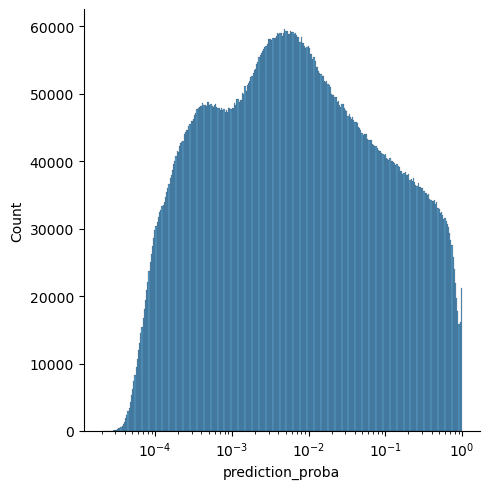

In [40]:
sns.displot(feature_df['prediction_proba'], log_scale=True)

In [86]:
feature_df[feature_df['prediction_proba'] > .95]

,mean,sum,std,n_reads_orf_vs_transcript,pos_1_vs_0,pos_2_vs_0,frames_1_vs_0,frames_2_vs_0,five_utr_vs_cds_mean,five_utr_vs_cds_max,five_utr_vs_start_codon_mean,five_utr_vs_start_codon_max,cds_utr_vs_start_codon_mean,cds_utr_vs_start_codon_max,three_utr_vs_cds_mean,three_utr_vs_cds_max,three_utr_vs_stop_codon_mean,three_utr_vs_stop_codon_max,cds_utr_vs_stop_codon_mean,cds_utr_vs_stop_codon_max,dist_neg_100,dist_neg_150,dist_pos_100,dist_pos_150,price,ribotish,ribocode,prediction,prediction_proba
orf_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
chr1_28236183_28237978_+_28236183-28236270|28236360-28236452|28237836-28237978_VPR-orfcalling-20240308012528-SRX11811978,0.428952,137.693463,1.253429,0.994231,0.039604,0.019802,0.100457,0.079909,1.020992,1.226170,1.690934,1.226170,1.081992,0.828230,1.484768,1.091080,2.373372,1.091080,1.092244,0.337753,-1.778151,-1.778151,-1.778151,-1.778151,15.431716,0.000000,24.991714,1,0.968296
chr1_46303766_46316584_+_46303766-46303820|46309100-46309127|46310154-46310316|46316551-46316584_VPR-orfcalling-20240308012528-SRX11811978,0.558235,154.072861,2.906693,0.977196,0.101449,0.084058,0.186727,0.114736,1.015573,1.458638,1.710399,1.458638,1.161760,0.821816,1.392419,1.100371,2.322219,1.100371,1.164192,0.336943,-1.778151,-1.778151,-1.778151,-1.778151,14.649946,0.000000,18.850341,1,0.956391
chr1_53015020_53050704_+_53015020-53015043|53027968-53028071|53038916-53039046|53047857-53047937|53050608-53050704_VPR-orfcalling-20240308012528-SRX11811978,0.195433,84.427133,0.549488,1.000000,0.296296,0.018519,0.157685,0.107784,0.674809,1.130334,1.351304,1.130334,1.102044,0.829304,1.247586,0.920819,1.799341,0.801632,0.618450,-0.119186,-1.778151,-1.778151,-1.778151,-1.778151,999.000000,0.000000,25.557393,1,0.959930
chr1_85259034_85259633_-_85259034-85259061|85259357-85259633_VPR-orfcalling-20240308012528-SRX11811978,0.044828,13.582914,0.151787,1.000000,10.000000,10.000000,0.189873,0.101266,3.000000,3.000000,3.000000,3.000000,0.954243,0.698970,1.189594,0.602060,1.924279,0.602060,0.857332,0.124939,-1.778151,-1.778151,-1.778151,-1.778151,14.528782,6.878942,7.672309,1,0.972806
chr2_101002701_101006381_+_101002701-101002808|101004157-101004283|101005958-101006071|101006349-101006381_VPR-orfcalling-20240308012528-SRX11811978,0.901864,340.904513,2.046494,0.998440,0.056604,0.000000,0.134990,0.112573,1.138779,1.423246,1.417195,1.423246,0.348871,0.071063,1.596742,1.469822,2.498311,1.469822,1.114346,0.239373,-1.778151,-1.778151,-1.778151,-1.778151,999.000000,0.000000,31.300754,1,0.955415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX_103357684_103357999_+_103357684-103357999_VPR-orfcalling-20240308012940-SRX876071,0.107608,33.896495,0.211098,1.000000,10.000000,10.000000,0.175824,0.736264,1.223706,0.954243,1.345700,0.698970,0.146128,-0.255273,1.474829,0.698970,2.100371,0.698970,0.711204,0.096910,-0.000000,-0.000000,-0.000000,-0.000000,999.000000,0.000000,10.390989,1,0.958228
chrX_135032383_135032725_+_135032383-135032725_VPR-orfcalling-20240308012940-SRX876071,0.168036,57.468196,0.376660,1.000000,0.000000,0.666667,0.102941,0.343137,0.657025,0.778151,1.025002,0.778151,0.477121,0.079181,3.000000,3.000000,3.000000,3.000000,0.580662,0.087150,-1.778151,-1.778151,-0.477121,-0.477121,999.000000,11.539668,12.799985,1,0.952940
chr11_2393895_2395127_+_2393895-2394192|2394971-2395127_VPR-orfcalling-20240308012940-SRX876071,0.077837,35.260147,0.264116,1.000000,10.000000,10.000000,0.081481,0.259259,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,8.417203,9.866714,1,0.955517


In [87]:
pred_df = feature_df[feature_df['prediction_proba'] > .95].copy()

In [88]:
pred_df['chrom'] = pred_df.apply(lambda x: x.name.split('_')[0], axis=1)

In [89]:
pred_df['dataset'] = pred_df.apply(lambda x: x.name.split('_')[-1], axis=1)

In [90]:
pred_df['orf_idx'] = pred_df.apply(lambda x: '_'.join(x.name.split('_')[:-1]), axis=1)

In [91]:
str_cols = ['orf_idx_str', 'chrom_id', 'orf_start', 'orf_end', 'strand', 'exon_blocks', 'orf_sequence']

pred_all_df = pred_df.merge(feature_all_df[str_cols], left_index=True, right_on='orf_id', how='left')

In [92]:
pred_all_df['aa'] = pred_all_df.apply(lambda x: str(Seq(x.orf_sequence).translate())[:-1], axis=1)

In [93]:
pred_all_df['length'] = pred_all_df.apply(lambda x: len(x.aa), axis=1)

In [94]:
pred_all_df = pred_all_df[pred_all_df['length'] > 14]

In [95]:
pred_all_df = pred_all_df[(pred_all_df['orf_sequence'].str.startswith('ATG')) | \
             (pred_all_df['orf_sequence'].str.startswith('CTG')) | \
             (pred_all_df['orf_sequence'].str.startswith('GTG'))]

In [96]:
len(set(pred_all_df['orf_sequence']))

2351

In [97]:
pred_all_df.to_csv('../data/top_orfs_gb-95_240318.csv')

In [98]:
dash_df = pd.read_csv('../data/sorf_selection_riboseq_240316.csv')

In [99]:
pred_aa_seqs = set(pred_all_df['aa'])

In [100]:
dash_aa_seqs = set(dash_df['aa'])

In [101]:
len(pred_aa_seqs.intersection(dash_aa_seqs))

867

In [102]:
len(pred_aa_seqs)

2340

In [103]:
len(pred_aa_seqs) - len(pred_aa_seqs.intersection(dash_aa_seqs))

1473

In [104]:
dash_updated_df = pd.read_csv('../data/sorf_selection_amended_240318.csv')

In [105]:
phase12_df = dash_updated_df[dash_updated_df.apply(lambda x: 'velia_phase12_riboseq_240317' in x.source, axis=1)]

In [107]:
phase12_df.columns

Index(['vtx_id', 'show_details', 'vtx_id.1', 'aa_length', 'ucsc_track',
       'source', 'screening_phase_id', 'screening_phase', 'genscript_id',
       'orf_xrefs', 'protein_xrefs', 'gene_xrefs', 'transcripts_exact', 'aa',
       'chr', 'strand', 'start', 'end', 'chrom_starts', 'block_sizes',
       'phases', 'blastp_subject', 'blastp_hit_description',
       'blastp_align_length', 'blastp_align_identity', 'tblastn_hit_id',
       'tblastn_description', 'tblastn_align_length', 'tblastn_align_identity',
       'Deepsig_score', 'SignalP 6slow_score', 'SignalP 5b_score',
       'SignalP 4.1_score', 'Deepsig_cut', 'SignalP 6slow_cut',
       'SignalP 5b_cut', 'SignalP 4.1_cut', 'Phobius', 'DeepTMHMM',
       'translated_mean', 'secreted_mean', 'secreted_hibit',
       'translated_hibit', 'phylocsf_58m_avg', 'phylocsf_58m_max',
       'phylocsf_58m_min', 'ESMFold plddt 90th percentile', 'MS_evidence',
       'swissprot_isoform', 'ensembl_isoform', 'refseq_isoform',
       'Ribo-Seq RPKM Su

In [108]:
phase12_df[(phase12_df['aa'].isin(pred_aa_seqs)) &  (phase12_df['Deepsig_cut'] > 0)]

,vtx_id,show_details,vtx_id.1,aa_length,ucsc_track,source,screening_phase_id,screening_phase,genscript_id,orf_xrefs,protein_xrefs,gene_xrefs,transcripts_exact,aa,chr,strand,start,end,chrom_starts,block_sizes,phases,blastp_subject,blastp_hit_description,blastp_align_length,blastp_align_identity,tblastn_hit_id,tblastn_description,tblastn_align_length,tblastn_align_identity,Deepsig_score,SignalP 6slow_score,SignalP 5b_score,SignalP 4.1_score,Deepsig_cut,SignalP 6slow_cut,SignalP 5b_cut,SignalP 4.1_cut,Phobius,DeepTMHMM,translated_mean,secreted_mean,secreted_hibit,translated_hibit,phylocsf_58m_avg,phylocsf_58m_max,phylocsf_58m_min,ESMFold plddt 90th percentile,MS_evidence,swissprot_isoform,ensembl_isoform,refseq_isoform,Ribo-Seq RPKM Support,Ribo-Seq sORF,nonsignal_seqs,DeepTMHMM_prediction,DeepTMHMM_length,nonsig_blastp_align_identity,nonsig_tblastn_align_identity,SNPS,MAPPED_TRAIT,P-VALUE
168,VTX-0001759,False,VTX-0001759,158,chr10:69088158-69104120,['ENSEMBL' 'velia_phase12_riboseq_240317' 'Ref...,-1,Not Screened,NaN,['cds-NP_002718.2'\n 'chr10_69088157_69104120_...,['161265' 'ENSP00000242465.3' 'P10124' 'SRGN'],ENSG00000122862.5;HGNC:9361;SRGN;5552;9361;gen...,['ENST00000242465.4'],MMQKLLKCSRLVLALALILVLESSVQGYPTRRARYQWVRCNPDSNS...,chr10,+,69088158,69104120,69088158;69097084;69103871,78;147;249,0;2;1,gnl|BL_ORD_ID|94844,XP_030100814.1 serglycin isoform X2 [Mus muscu...,150.0,0.506667,XM_006513374.5,XM_006513374.5 PREDICTED: Mus musculus serglyc...,136.0,48.529,0.99,0.9999,0.997486,0.903,27,27,27,27,-1,27,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,False,['ENSP00000242465.3'],['P10124'],['NP_001307982.1' 'NP_002718.2' 'NP_001307983.1'],False,True,YPTRRARYQWVRCNPDSNSANCLEEKGPMFELLPGESNKIPRLRTD...,False,0,48.739,48.739,NaN,NaN,NaN
411,VTX-0005220,False,VTX-0005220,198,chr9:128149526-128153119,['ENSEMBL' 'velia_phase12_riboseq_240317' 'Ref...,-1,Not Screened,NaN,['cds-XP_047279332.1'\n 'chr9_128149525_128153...,['164284' 'ENSP00000362108.1' 'LCN2' 'P80188'],ENSG00000148346.12;HGNC:6526;LCN2;3934;6526;ge...,['ENST00000373017.5' 'ENST00000277480.7'],MPLGLLWLGLALLGALHAQAQDSTSDLIPAPPLSKVPLQQNFQDNQ...,chr9,+,128149526,128153119,128149526;128150238;128151638;128151906;128152...,137;136;79;119;101;19,0;0;1;2;2;2,gnl|BL_ORD_ID|76273,NP_032517.1 neutrophil gelatinase-associated l...,29.0,0.517241,NM_008491.1,"NM_008491.1 Mus musculus lipocalin 2 (Lcn2), mRNA",181.0,62.431,1.00,0.9998,0.999269,0.873,20,20,20,20,-1,20,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,False,['ENSP00000362108.1'],['P80188'],['NP_005555.2' 'XP_047279332.1'],False,True,QDSTSDLIPAPPLSKVPLQQNFQDNQFQGKWYVVGLAGNAILREDK...,False,0,62.011,62.011,NaN,NaN,NaN
446,VTX-0005672,False,VTX-0005672,161,chr11:119419408-119420905,['ENSEMBL' 'velia_phase12_riboseq_240317' 'vel...,-1,Not Screened,NaN,['CDS_ENST00000284240.10' 'cds-NP_006279.2'\n ...,['160495' '84834' 'B0YJA4' 'ENSP00000284240.6'...,11801;7070;ENSG00000154096.14;gene-THY1;HGNC:1...,['ENST00000284240.10' 'ENST00000528522.5'],MNLAISIALLLTVLQVSRGQKVTSLTACLVDQSLRLDCRHENTSSS...,chr11,-,119419408,119420905,119419408;119420051;119420869,112;335;36,2;2;0,gnl|BL_ORD_ID|60708,NP_033408.1 thy-1 membrane glycoprotein prepro...,36.0,0.305556,NM_009382.3,NM_009382.3 Mus musculus thymus cell antigen 1...,162.0,69.753,0.99,0.9999,0.992632,0.862,19,19,19,19,-1,19,NaN,NaN,False,NaN,NaN,NaN,NaN,0.0,False,['ENSP00000284240.6' 'ENSP00000435753.1' 'ENSP...,['B0YJA4'],['NP_006279.2' 'NP_001298089.1' 'NP_001298091.1'],False,True,QKVTSLTACLVDQSLRLDCRHENTSSSPIQYEFSLTRETKKHVLFG...,False,0,67.606,67.606,NaN,NaN,NaN
671,VTX-0008543,False,VTX-0008543,197,chr6:109368851-109382378,['ENSEMBL' 'velia_phase12_riboseq_240317' 'Ref...,-1,Not Screened,NaN,['cds-NP_006007.2'\n 'chr6_109368850_109382378...,['164653' 'CD164' 'ENSP00000402237.2' 'Q04900'],1632;8763;CD164;CD164;ENSG00000135535.17;gene-...,['ENST00000310786.10'],MSRLSRSLLWAATCLGVLCVLSADKNTTQHPNVTTLAPISNVTSAP...,chr6,-,109368851,109382378,109368851;109370411;109376074;109377900;109379...,166;56;38;71;83;174,2;2;2;2;2;

In [82]:
len(set(x_aa).intersection(pred_aa_seqs))

733

In [92]:
pred_all_df.groupby('chrom').count()

,mean,sum,std,n_reads_orf_vs_transcript,pos_1_vs_0,pos_2_vs_0,frames_1_vs_0,frames_2_vs_0,five_utr_vs_cds_mean,five_utr_vs_cds_max,five_utr_vs_start_codon_mean,five_utr_vs_start_codon_max,cds_utr_vs_start_codon_mean,cds_utr_vs_start_codon_max,three_utr_vs_cds_mean,three_utr_vs_cds_max,three_utr_vs_stop_codon_mean,three_utr_vs_stop_codon_max,cds_utr_vs_stop_codon_mean,cds_utr_vs_stop_codon_max,dist_neg_100,dist_neg_150,dist_pos_100,dist_pos_150,price,ribotish,ribocode,prediction,prediction_proba,dataset,orf_idx,orf_idx_str,chrom_id,orf_start,orf_end,strand,exon_blocks,orf_sequence,aa,length
chrom,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GL000250.2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
GL000251.2,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
GL000252.2,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
GL000253.2,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
GL000254.2,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
GL000255.2,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
GL000256.2,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
GL339449.2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
GL383575.2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


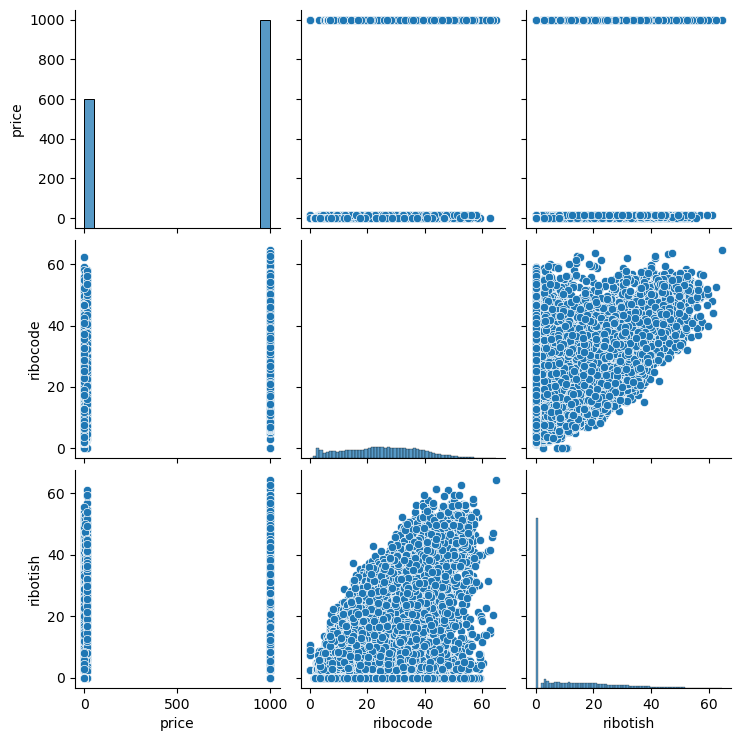

In [93]:
sns.pairplot(pred_all_df[['price', 'ribocode', 'ribotish']])

In [100]:
pred_all_df['ucsc_str'] = pred_all_df.apply(lambda x: f'{x.chrom}:{x.orf_start}-{x.orf_end}', axis=1)

In [112]:
top_df = pred_all_df[~pred_all_df['aa'].isin(dash_aa_seqs)]

In [127]:
top_df[~top_df['exon_blocks'].str.contains('\|')][['ucsc_str']][0:100]

,ucsc_str
orf_id,
chr18_11851511_11852111_+_11851511-11852111_VPR-orfcalling-20240308012528-SRX11811978,chr18:11851511-11852111
chr11_2395196_2395592_+_2395196-2395592_VPR-orfcalling-20240308012528-SRX11811978,chr11:2395196-2395592
chr11_2395799_2396273_+_2395799-2396273_VPR-orfcalling-20240308012528-SRX11811978,chr11:2395799-2396273
chr17_7309635_7309884_+_7309635-7309884_VPR-orfcalling-20240308012528-SRX11811978,chr17:7309635-7309884
chr9_8713310_8713721_+_8713310-8713721_VPR-orfcalling-20240308012528-SRX11811978,chr9:8713310-8713721
chr18_49491481_49491571_-_49491481-49491571_VPR-orfcalling-20240308012528-SRX11811978,chr18:49491481-49491571
chr5_73499133_73499379_+_73499133-73499379_VPR-orfcalling-20240308012528-SRX11811978,chr5:73499133-73499379
chr12_112408338_112408656_-_112408338-112408656_VPR-orfcalling-20240308012528-SRX11811978,chr12:112408338-112408656
chrX_154400383_154400701_+_154400383-154400701_VPR-orfcalling-20240308012528-SRX11811978,chrX:154400383-154400701


In [115]:
top_df.groupby('ucsc_str').count().sort_values(by='mean', ascending=False)

,mean,sum,std,n_reads_orf_vs_transcript,pos_1_vs_0,pos_2_vs_0,frames_1_vs_0,frames_2_vs_0,five_utr_vs_cds_mean,five_utr_vs_cds_max,five_utr_vs_start_codon_mean,five_utr_vs_start_codon_max,cds_utr_vs_start_codon_mean,cds_utr_vs_start_codon_max,three_utr_vs_cds_mean,three_utr_vs_cds_max,three_utr_vs_stop_codon_mean,three_utr_vs_stop_codon_max,cds_utr_vs_stop_codon_mean,cds_utr_vs_stop_codon_max,dist_neg_100,dist_neg_150,dist_pos_100,dist_pos_150,price,ribotish,ribocode,prediction,prediction_proba,chrom,dataset,orf_idx,orf_idx_str,chrom_id,orf_start,orf_end,strand,exon_blocks,orf_sequence,aa,length
ucsc_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
chr1:23691823-23696373,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180
chr12:56158401-56161415,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171,171
chr17:7309635-7311640,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138
chr18:49488518-49491571,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127
chr7:22511435-22511999,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr2:241680307-241686783,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
chr2:241678474-241686783,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
chr2:241637714-241659175,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


<Axes: xlabel='length', ylabel='Density'>

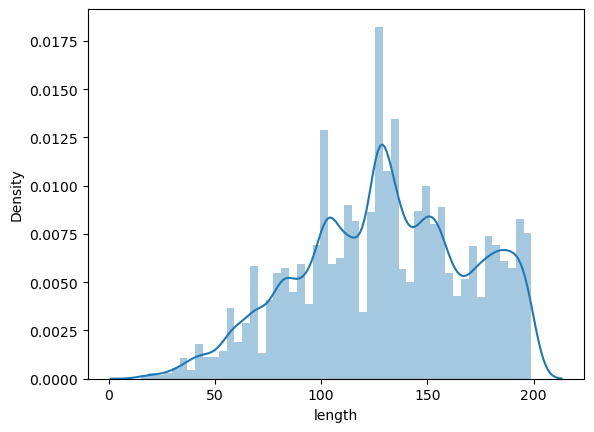

In [98]:
sns.distplot(pred_all_df['length'])

In [ ]:
dashboard_update --overwrite --run_protein_tools --number_threads 32 /home/ubuntu/repos/dashboard/scripts/cache_updates/velia_phase12_riboseq_240317_vtx-ids.txt /home/ubuntu/repos/dashboard/cache_ribo12 /home/ubuntu/repos/dashboard/data/